# Batch Optimization

We provide an example of how to update parameters on a batch of data. In these toy examples, we show different ways to update parameters of functions on data containing multiple inputs. For simplicity, we consider batch update without random sampling.

In [ ]:
%pip install trace-opt ipywidgets

As a preamble, the code below provides a way to specify your API_KEY for calling LLMs using LiteLLM as part of this tutorial notebook. Alternatively, provide the keys by setting environment variables or loading LiteLLM config files.

In [ ]:
import os
import ipywidgets as widgets
from IPython.display import display

# Function to save the environment variable and API key
def save_env_variable(env_name, api_key):
    # Validate inputs
    if not env_name.strip():
        print("⚠️ Environment variable name cannot be empty.")
        return
    if not api_key.strip():
        print("⚠️ API key cannot be empty.")
        return
    
    # Store the API key as an environment variable
    os.environ[env_name] = api_key
    globals()[env_name] = api_key  # Set it as a global variable
    print(f"✅ API key has been set for environment variable: {env_name}")

# Create the input widgets
env_name_input = widgets.Text(
    value="OPENAI_API_KEY",  # Default value
    description="Env Name:",
    placeholder="Enter env variable name (e.g., MY_API_KEY)",
)

api_key_input = widgets.Password(
    description="API Key:",
    placeholder="Enter your API key",
)

# Create the button to submit the inputs
submit_button = widgets.Button(description="Set API Key")

# Display the widgets
display(env_name_input, api_key_input, submit_button)

# Callback function for the button click
def on_button_click(b):
    env_name = env_name_input.value
    api_key = api_key_input.value
    save_env_variable(env_name, api_key)

# Attach the callback to the button
submit_button.on_click(on_button_click)

First, we consider a small linear regression problem. To perform updates on multiple inputs at a time, here we just compute the loss for each input and then sum it up, and perform one `backward` call to tell the optimizer to minimize the loss. Since the optimizer is capable of seeing the graph, it can understand how different inputs and labels are paired and evaluated by the loss function.

In [33]:
import random
import numpy as np

random.seed(0)
np.random.seed(0)

from opto import trace
from opto.optimizers import OptoPrime


def true_fun(x):
    return 2*x  - 3

inputs = [3, 2, 1, 5, 4]
outputs = [true_fun(x) for x in inputs]
N = len(inputs)


@trace.bundle()
def loss(y_hat, y):
    """ A least squares loss function. """
    return (y_hat - y) ** 2



Iteration 0 Loss: 85
Iteration 1 Loss: 85
Iteration 2 Loss: 10
Iteration 3 Loss: 15
Iteration 4 Loss: 10
Iteration 5 Loss: 40
Iteration 6 Loss: 0
Iteration 7 Loss: 0
Iteration 8 Loss: 0
Iteration 9 Loss: 0
Iteration 10 Loss: 0
Iteration 11 Loss: 0
Iteration 12 Loss: 0
Iteration 13 Loss: 0
Iteration 14 Loss: 0


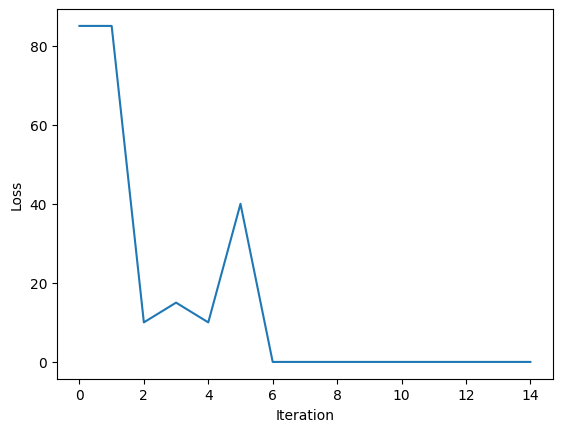

In [34]:
trace.GRAPH.clear()

@trace.bundle(trainable=True)
def fun(x):
    """ A linear predictor function """
    return 0

def compute_loss(inputs, outputs):
    l = 0
    for x,y in zip(inputs, outputs):
        y_hat = fun(x)
        l += loss(y_hat, y)
    return l

optimizer = OptoPrime(fun.parameters())

ls = []
for i in range(15):
    try:
        l = compute_loss(inputs, outputs)
        target = l
        feedback = 'Minimize loss'
        print(f'Iteration {i} Loss: {l.data}')
        ls.append(l.data)
    except trace.ExecutionError as e:
        target = e.exception_node
        feedback = str(e.exception_node.data)

    optimizer.zero_feedback()
    optimizer.backward(target, feedback)
    optimizer.step()

# plot ls
import matplotlib.pyplot as plt
plt.plot(ls)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In contrast, if we update the parameter without batching but in a purely online fashion one by one, then the optimization results can be more noisy sometimes.

Iteration 0 Loss: 85
Iteration 1 Loss: 10
Iteration 2 Loss: 10
Iteration 3 Loss: 120
Iteration 4 Loss: 120
Iteration 5 Loss: 120
Iteration 6 Loss: 60
Iteration 7 Loss: 30
Iteration 8 Loss: 30
Iteration 9 Loss: 15
Iteration 10 Loss: 10
Iteration 11 Loss: 10
Iteration 12 Loss: 15
Iteration 13 Loss: 55
Iteration 14 Loss: 15


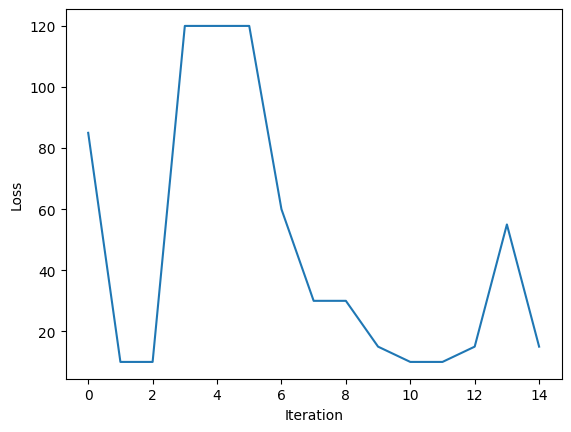

In [16]:


trace.GRAPH.clear()

@trace.bundle(trainable=True)
def fun(x):
    """ A linear predictor function """
    return 0

optimizer = OptoPrime(fun.parameters())

ls = []
for i in range(15):
    try:
        l_eval = compute_loss(inputs, outputs)
        print(f'Iteration {i} Loss: {l_eval.data}')
        ls.append(l_eval.data)

        ind = np.random.randint(0, N) % N
        target = compute_loss([inputs[ind]], [outputs[ind]])
        feedback = 'Minimize loss'
    except trace.ExecutionError as e:
        target = e.exception_node
        feedback = str(e.exception_node.data)

    optimizer.zero_feedback()
    optimizer.backward(target, feedback)
    optimizer.step()



# plot ls
import matplotlib.pyplot as plt
plt.plot(ls)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()


## Batching Non-Commutative Feedbacks

In the earlier numerical example, the loss function was commutative so that we can do  `batch_loss += loss(each_input)`. What if the feedbacks received are not commutative? This can happen often with non-numeric (e.g. text) feedbacks. Here we will see a simple design pattern for using `trace` and `OptoPrime` for batch optimization in such cases.

In [17]:
from opto.trace import bundle

@bundle(trainable=False)
def concat(*items):
    """ Concatenate the items into a single string """
    output = ''
    for i, item in enumerate(items):
        output += f'ID {[i]}: {item}\n'
    return output

Note that the `concat` function when called with a list of feedbacks will concatenate them all with an identifier for each element. This way, the optimizer when given a batch of outputs and a corresponding batch of feedbacks can disambiguate which feedback corresponds to which output.

In [18]:
@bundle(trainable=True)
def strange_sort_list(lst):
    '''
    Given list of integers, return list in strange order.
    Strange sorting, is when you start with the minimum value,
    then maximum of the remaining integers, then minimum and so on.
    '''
    lst = sorted(lst)
    return lst

def get_feedback(predict, target):
    if predict == target:
        return "test case passed!"
    else:
        return "test case failed!"
    
from opto.optimizers import OptoPrime

test_ground_truths = [[1, 4, 2, 3], [5, 5, 5, 5], [], [4, 9, 5, 8, 6, 7]]
test_inputs = [[1, 2, 3, 4], [5, 5, 5, 5], [], [9, 8, 7, 6, 5, 4]]

optimizer = OptoPrime(strange_sort_list.parameters())

outputs = []
feedbacks = []
for i in range(len(test_inputs)):
    try:
        test_output = strange_sort_list(test_inputs[i])
        feedback = get_feedback(test_output, test_ground_truths[i])
    except trace.ExecutionError as e:
        feedback = e.exception_node.data
        test_output = e.exception_node
    feedbacks.append(feedback)
    
    correctness = test_output.eq(test_ground_truths[i])
    outputs.append(correctness)

batched_feedback = concat(*feedbacks)
batched_outputs = concat(*outputs)
optimizer.zero_feedback()
optimizer.backward(batched_outputs, batched_feedback.data)
optimizer.step(verbose=True)

Prompt
 
You're tasked to solve a coding/algorithm problem. You will see the instruction, the code, the documentation of each function used in the code, and the feedback about the execution result.

Specifically, a problem will be composed of the following parts:
- #Instruction: the instruction which describes the things you need to do or the question you should answer.
- #Code: the code defined in the problem.
- #Documentation: the documentation of each function used in #Code. The explanation might be incomplete and just contain high-level description. You can use the values in #Others to help infer how those functions work.
- #Variables: the input variables that you can change.
- #Constraints: the constraints or descriptions of the variables in #Variables.
- #Inputs: the values of other inputs to the code, which are not changeable.
- #Others: the intermediate values created through the code execution.
- #Outputs: the result of the code output.
- #Feedback: the feedback about the code

{<opto.trace.nodes.ParameterNode at 0x76bc1c70ab80>: "def strange_sort_list(lst):\n    '''\n    Given list of integers, return list in strange order.\n    Strange sorting, is when you start with the minimum value,\n    then maximum of the remaining integers, then minimum and so on.\n    '''\n    lst = sorted(lst)\n    result = []\n    while lst:\n        result.append(lst.pop(0))  # take min\n        if lst:\n            result.append(lst.pop(-1))  # take max\n    return result"}

## Using the functions in `opto.trainer` to perform Batching

In the earlier examples, we wrote our own design patterns for accomplishing batch optimization. However, Trace provides the `MiniBatchAlgorithm` to accomplish this automatically.
Let us see how the abstractions in `opto.trainer` allow us to scale up optimization, for example, doing minibatch optimization on the GSM 8K Dataset, which is a dataset of math word problems.

In [19]:
import datasets
import numpy as np

train_dataset = datasets.load_dataset('openai/gsm8k', 'main')['train'][:10]
train_dataset = dict(inputs=train_dataset['question'], infos=train_dataset['answer'])
test_dataset = train_dataset

# set seed
seed = 42
num_epochs = 1
batch_size = 2
test_frequency = -1
num_threads = 3
verbose = True

np.random.seed(seed)

We define the `Learner` agent which is a student LLM with a trainable system prompt. Trace will use a generative optimizer to tune the system prompt. Trace provides also a class for LLM-as-Judge called `VerbalJudgeGuide` that uses a Teacher LLM to provide rich feedbacks to the student LLM. 

In [20]:
from opto import trace
from opto.utils.llm import LLM
from opto.optimizers import OptoPrime
from opto.trainer.algorithms.basic_algorithms import MinibatchAlgorithm
from opto.trainer.loggers import TensorboardLogger
from opto.trainer.guide import VerbalJudgeGuide
from typing import Any

@trace.model
class Learner:
    """ A basic LLM agent. """

    def __init__(self, system_prompt: str = "You're a helpful agent",
                 user_prompt_template: str = "Query: {message}",
                 llm: LLM = None):
        self.system_prompt = trace.node(system_prompt, trainable=True)
        self.user_prompt_template = trace.node(user_prompt_template)
        self.llm = llm or LLM()

    @trace.bundle()
    def model(self, system_prompt: str, user_prompt_template: str, message: str) -> str:
        """Call the LLM model.

        Args:
            system_prompt: the system prompt to the agent. By tuning this prompt, we can control the behavior of the agent. For example, it can be used to provide instructions to the agent (such as how to reason about the problem, how to answer the question), or provide in-context examples of how to solve the problem.
            user_prompt_template: the user prompt template to the agent. It is used as formatting the input to the agent as user_prompt_template.format(message=message).
            message: the input to the agent. It can be a query, a task, a code, etc.
        Returns:
            The response from the agent.
        """

        if '{message}' not in user_prompt_template:
            raise ValueError("user_prompt_template must contain '{message}'")

        response = self.llm(
            messages=[{"role": "system", "content": system_prompt},
                      {"role": "user", "content": user_prompt_template.format(message=message)}]
        )
        return response.choices[0].message.content

    def forward(self, message: Any) -> Any:
        """ Forward pass of the agent. """
        return self.model(self.system_prompt, self.user_prompt_template, message)


Finally, we use the `MiniBatchAlgorithm` as the trainer to sample batches from the GSM8K dataset, run the student model on the samples, gather feedback from the teacher model, and present the resulting traced graph to the optimizer.

In [21]:
agent = Learner(llm=LLM())
guide = VerbalJudgeGuide(llm=LLM())
optimizer = OptoPrime(agent.parameters(), llm=LLM())
logger = TensorboardLogger(verbose=True)

alg = MinibatchAlgorithm(
            agent=agent,
            optimizer=optimizer,
            logger=logger)

import nest_asyncio
nest_asyncio.apply()
import asyncio

async def wrapper():
    print("STARTING TRAINING")
    alg.train(guide,
              train_dataset,
              num_epochs=num_epochs,
              batch_size=batch_size,
              test_frequency=test_frequency,
              test_dataset=test_dataset,
              num_threads=num_threads,
              verbose='output')
    print("FINISHED TRAINING")
    
asyncio.run(wrapper())

STARTING TRAINING


Forward pass (batch size: 2): 100%|██████████| 2/2 [00:06<00:00,  3.12s/it]


LLM response:
 {
"reasoning": "The #Instruction asks us to change the values of the variables in #Variables to improve the output according to #Feedback. The #Feedback section provides the analysis of the answers generated for each query. Both answers for the queries (regarding Alexis and Weng) are correct, as indicated by the statement 'Correct [TERMINATE]'. The #Output shows that the responses generated for each model (Learner.model0 and Learner.model1) are logical and correct given the input prompts. Therefore, there are no errors in the current setup, and no changes are needed in the variables.",
"answer": "TERMINATE",
"suggestion": {}
}


Evaluating agent (iteration 1): 100%|██████████| 10/10 [00:22<00:00,  2.30s/it]


[Step 1] Average test score: 1.0
Epoch: 0. Iteration: 1
[Step 1] Instantaneous train score: 1.0
[Step 1] Average train score: 1.0
[Step 1] Parameter: str:20: You're a helpful agent


Forward pass (batch size: 2): 100%|██████████| 2/2 [00:09<00:00,  4.65s/it]
/home/aswaminathan/miniconda3/envs/trace/lib/python3.9/copy.py:263: RuntimeWarning: coroutine 'main' was never awaited
  args = (deepcopy(arg, memo) for arg in args)


LLM response:
 {
"reasoning": "The instruction asks us to change the value of variables if necessary to improve the output based on the feedback provided. In this instance, the feedback for both outputs (ID [0] and ID [1]) states 'Correct' and suggests termination, which indicates that the outputs match the expected results. The variables in the code that we have control over are used to set up prompts for an LLM model to process. The feedback shows the model's output correctly answers the questions based on the inputs, matching the expected correct answers outlined in the feedback. Therefore, no changes to the variables are necessary as the task is operating as intended.",
"answer": "TERMINATE",
"suggestion": {}
}


Evaluating agent (iteration 2): 100%|██████████| 10/10 [00:18<00:00,  1.88s/it]


[Step 2] Average test score: 1.0
Epoch: 0. Iteration: 2
[Step 2] Instantaneous train score: 1.0
[Step 2] Average train score: 1.0
[Step 2] Parameter: str:20: You're a helpful agent


Forward pass (batch size: 2): 100%|██████████| 2/2 [00:04<00:00,  2.46s/it]


LLM response:
 {
  "reasoning": "The #Instruction asks us to adjust the #Variables to improve the output based on #Feedback. The feedback suggests that the answers provided by the models are correct for both IDs. The output of both Learner.model25 and Learner.model24 correctly represents the calculation processes needed to answer the given queries. As the feedback indicates '[TERMINATE]', it means the current outputs are satisfactory, and no changes to the #Variables are necessary.",
  "answer": "TERMINATE"
}


Evaluating agent (iteration 3): 100%|██████████| 10/10 [00:20<00:00,  2.05s/it]


[Step 3] Average test score: 1.0
Epoch: 0. Iteration: 3
[Step 3] Instantaneous train score: 1.0
[Step 3] Average train score: 1.0
[Step 3] Parameter: str:20: You're a helpful agent


Forward pass (batch size: 2): 100%|██████████| 2/2 [00:08<00:00,  4.16s/it]


LLM response:
 {
"reasoning": "The #Instruction requires us to change the values in #Variables to improve the output. However, based on #Feedback, both IDs in the #Outputs are correctly calculated according to the logic specified in #Documentation and supported by expert feedback. Therefore, no changes are needed to improve the outputs, as they already match the expected results provided in the feedback.",
"answer": "Both outputs are correct as per the feedback.",
"suggestion": {}
}


Evaluating agent (iteration 4): 100%|██████████| 10/10 [00:19<00:00,  1.91s/it]


[Step 4] Average test score: 1.0
Epoch: 0. Iteration: 4
[Step 4] Instantaneous train score: 1.0
[Step 4] Average train score: 1.0
[Step 4] Parameter: str:20: You're a helpful agent


Forward pass (batch size: 2): 100%|██████████| 2/2 [00:05<00:00,  2.63s/it]


LLM response:
 {
"reasoning": "The #Instruction requires adjusting the value of the variable in #Variables to improve the output based on #Feedback. In this scenario, the feedback has been provided for both outputs (ID [0] and ID [1]) as correct, with an explicit [TERMINATE] instruction from the expert feedback, indicating that no changes are needed for the variable's value, as the outputs align perfectly with the expected answers. The current settings in #Variables, #Inputs, and #Others, including the prompts and message, are correctly leading to the generation of accurate answers to the queries, both for Julie's reading task and Albert's pizza consumption problem.",
"answer": "TERMINATE",
"suggestion": {}
}


Evaluating agent (iteration 5): 100%|██████████| 10/10 [00:17<00:00,  1.76s/it]

[Step 5] Average test score: 1.0
Epoch: 0. Iteration: 5
[Step 5] Instantaneous train score: 1.0
[Step 5] Average train score: 1.0
[Step 5] Parameter: str:20: You're a helpful agent
FINISHED TRAINING
